In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [3]:
import numpy as np
from scipy.stats import kendalltau
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestRegressor

In [4]:
def read_memfile(filename, shape, dtype='float32'):
    # read binary data and return as a numpy array
    fp = np.memmap(filename, dtype=dtype, mode='r', shape=shape)
    data = np.zeros(shape=shape, dtype=dtype)
    data[:] = fp[:]
    del fp
    return data

In [5]:
def write_memfile(data, filename):
    # write a numpy array 'data' into a binary  data file specified by
    # 'filename'
    shape = data.shape
    dtype = data.dtype
    fp = np.memmap(filename, dtype=dtype, mode='w+', shape=shape)
    fp[:] = data[:]
    del fp

In [6]:
ROOT_DIR = '/rap/jvb-000-aa/COURS2019/etudiants/data/omsignal/myHeartProject/'
TRAIN_LABELED_FILE = 'MILA_TrainLabeledData.dat'
VALIDATION_LABELED_FILE =  'MILA_ValidationLabeledData.dat'

TRAIN_LABELED_FILE = 'MILA_TrainLabeledData.dat'
VALIDATION_LABELED_FILE = 'MILA_ValidationLabeledData.dat'
LABELS_NAME = ["PR_Mean", "RT_Mean", "RR_StdDev", "ID"]

train_labeled_data_file = os.path.join(ROOT_DIR, TRAIN_LABELED_FILE)
validation_labeled_data_file = os.path.join(ROOT_DIR, VALIDATION_LABELED_FILE)

In [7]:
datatrain = read_memfile(train_labeled_data_file, shape=(160,3754))
train_data, train_labels = datatrain[:,:-4], datatrain[:,-4:]

In [8]:
datavalid = read_memfile(validation_labeled_data_file, shape=(160,3754))
valid_data, valid_labels = datavalid[:,:-4], datavalid[:,-4:]

In [9]:
class Preprocessor(nn.Module):

    def __init__(
            self,
            ma_window_size=2,
            mv_window_size=4,
            num_samples_per_second=125):
        # ma_window_size: (in seconds) window size to use
        #                 for moving average baseline wander removal
        # mv_window_size: (in seconds) window size to use
        #                 for moving average RMS normalization

        super(Preprocessor, self).__init__()

        # Kernel size to use for moving average baseline wander removal: 2
        # seconds * 125 HZ sampling rate, + 1 to make it odd

        self.maKernelSize = (ma_window_size * num_samples_per_second) + 1

        # Kernel size to use for moving average normalization: 4
        # seconds * 125 HZ sampling rate , + 1 to make it odd

        self.mvKernelSize = (mv_window_size * num_samples_per_second) + 1

    def forward(self, x):

        with torch.no_grad():
            x = x.unsqueeze(0)
            

            # Remove window mean and standard deviation

            x = (x - torch.mean(x, dim=2, keepdim=True)) / \
                (torch.std(x, dim=2, keepdim=True) + 0.00001)

            # Moving average baseline wander removal

            x = x - F.avg_pool1d(
                x, kernel_size=self.maKernelSize,
                stride=1, padding=(self.maKernelSize - 1) // 2
            )

            # Moving RMS normalization

            x = x / (
                torch.sqrt(
                    F.avg_pool1d(
                        torch.pow(x, 2),
                        kernel_size=self.mvKernelSize,
                        stride=1, padding=(self.mvKernelSize - 1) // 2
                    )) + 0.00001
            )

        # Don't backpropagate further

        x = x.detach().contiguous()

        return x.squeeze(0)

In [10]:
def Plot_ECG(data, start=0, end=30, index_nb=[0], seconde=True):
    """
    Plot the ECG on a user defined time interval
    
    Parameters
    ----------
    data : numpy array
        The ECG Data
    start: int
        The starting time of the part of the ECG you want to plot
    end: int
        The End time of the part of the ECG you want to plot
    index_nb: List
        The index of the observation you want to plot
    seconde: boolean
        Used True if the start time is in seconde
    """
    # Adjust the shape in order to have 2 dimension
    if len(data.shape) == 1:
        data = np.expand_dims(data, axis=0)
        
    # Transform the start and end time 
    if seconde == True:
        start = start*125
        end = end*125
        
    x_labels = np.arange(start, end)
             
    for i, ex in enumerate(index_nb):
        plt.figure(i*2+1) 
        plt.plot(x_labels, data[ex, start:end])
        
    plt.show

In [11]:
class id_trasformer:
    def __init__(self):
        self.DictId2Class = {}
        self.DictClass2Id = {}
        self.n_Id = 0 
        
    def create_dict_ID(self, ID_vector):
        for id in ID_vector:
            if id not in self.DictId2Class:
                self.DictId2Class[id] = self.n_Id
                self.DictClass2Id[self.n_Id] = id
                self.n_Id += 1
                
    def Id2Class(self, ID_vector):
        return [self.DictId2Class[id] for id in ID_vector]
    
    def Class2Id(self, class_vector):
        return [self.DictClass2Id[labels] for labels in class_vector]

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [13]:
preprocessor = Preprocessor().to(device)

In [14]:
train = torch.tensor(train_data).to(device)
valid =  torch.tensor(valid_data).to(device)
preprocess_train = preprocessor(train)
preprocess_valid = preprocessor(valid)

In [15]:
idtransformer = id_trasformer()
idtransformer.create_dict_ID(train_labels[:,-1])
train_labels[:,-1] = idtransformer.Id2Class(train_labels[:,-1])
valid_labels[:,-1] = idtransformer.Id2Class(valid_labels[:,-1])

Algo to detect R P,T peak and onset offset based on https://pure.tugraz.at/ws/portalfiles/portal/1312717/Online%20and%20Offline%20Determination%20of%20QT%20PR%20in%20Electrocardiography%20LNCS%207719.pdfdf.pdf

In [16]:
def detect_R_peak(data, SADA_wd_size = 7, FS_wd_size = 12, Threshold = 35):
    """
    Take a Batch of ECG data and find the location of the R Peak
    
    The algorithm is based on the paper:
    Online and Offline Determination of QT and PR Interval and QRS Duration in Electrocardiography
    (Bachler et al., 2012)
    The variable name and default value follow the paper
    
    Parameters
    ----------
    data : numpy array
        The ECG Data (batch size x lenght of the ECG recording)
    SADA_wd_size: int
        size of the moving window used in the calculation of SA and DA
    FS_wd_size: int
        size of the moving window used in the calculation of the feature signal FS
    Threshold: int
        FS is compared to the Threshold to determined if its a QRS zone. 
    """
    
    R_peak = []
    
    #Allow batch size of 1
    if len(data.size()) == 1:
        data = data.unsqueeze(0)
    
    D = data[:, 1:] - data[:, 0:-1]
    
    
    data = data.unsqueeze(0)
    D = D.unsqueeze(0)
    SA = F.max_pool1d(data, kernel_size = SADA_wd_size, stride = 1)
    SA = SA + F.max_pool1d(-data, kernel_size = SADA_wd_size, stride = 1) 
    DA = F.max_pool1d(D, kernel_size = SADA_wd_size, stride = 1, padding=1)
    DA = DA + F.max_pool1d(-D, kernel_size = SADA_wd_size, stride = 1, padding=1) 
    
    C = DA[:,:,1:] * torch.pow(SA, 2)
    FS = F.max_pool1d(C, kernel_size = FS_wd_size, stride = 1) 
    Detect = (FS > Threshold)
    
    Detect = Detect.squeeze(0).cpu()
    data = data.squeeze(0).cpu()

    for ECG in range(len(data)):
        
        in_QRS = 0
        start_QRS = 0
        end_QRS = 0
        r_peak = np.array([])
        
        for tick, detect in enumerate(Detect[ECG]):
            
            if (in_QRS == 0) and (detect == 1):
                start_QRS = tick
                in_QRS = 1
                
            elif (in_QRS == 1) and (detect == 0):
                end_QRS = tick
                R_tick = torch.argmax(data[ECG, start_QRS : end_QRS+SADA_wd_size+FS_wd_size]).item()
                r_peak = np.append(r_peak, R_tick + start_QRS)
                in_QRS = 0
                start_QRS = 0
                
        R_peak.append(r_peak)
        
    return R_peak

In [17]:
R_peak_train = detect_R_peak(preprocess_train)
R_peak_valid = detect_R_peak(preprocess_valid)

In [18]:
def Get_RR_Mean_std(R_peak, MaxInterval=180):
    """
    Calculate the mean RR interval and the std
    
    Parameters
    ----------
    R_peak : list of list
        Each entry is a list of the positiion of the R peak in the ECG
    MaxInterval: int
        maximum lenght of an interval, interval higher than this amount are ignore
    """
    #calculate the lenght of the interval
    RR_interval = [R_peak[i][1:]-R_peak[i][0:-1] for i in range(len(R_peak))]
    
    #We keep only good quality one
    RR_interval_adj = [interval[interval<180] for interval in RR_interval]
    

    RR_interval_mean = [np.mean(interval) for interval in RR_interval_adj]    
    RR_std = [np.std(interval) for interval in RR_interval_adj]
    
    return RR_interval_mean, RR_std

In [19]:
Train_RR_mean, Train_RR_std = Get_RR_Mean_std(R_peak_train)
Valid_RR_mean, Valid_RR_std = Get_RR_Mean_std(R_peak_valid)

In [20]:
def create_template(data, R_peak, template_size = 110, All_window = True):
    
    listoftemplate1 = []
    listoftemplate2 = []
    half_size_int = template_size//2
    listECG_id = []
    
    for recording in range(len(data)):
        template = []
        ECG_id = []
        #generate the template      
        
        for i in R_peak[recording][1:-1]:
            new_heart_beat = data[recording][int(i)-int(half_size_int*0.8): int(i)+int(half_size_int*1.2)]
            if len(new_heart_beat) != 110:
                print("error")
            template.append(new_heart_beat)
            
            if All_window:
                ECG_id.append(recording)        

        if All_window == False:
            template = np.mean(template, axis = 0)
            template = np.expand_dims(template, axis = 0)
            ECG_id.append(recording)  
            
        listoftemplate1 = listoftemplate1 + template
        listECG_id = listECG_id + ECG_id
        
        
    #listoftemplate = [hearth_beat for hearth_beat in template for template in listoftemplate]
    return np.array(listoftemplate1), np.array(listECG_id)

In [21]:
def create_template_average(data, R_peak, template_size = 110):
    half_size_int = template_size//2
    listoftemplate = []
    for recording in range(len(R_peak)):
        #generate the template
        template = np.zeros((1,int(half_size_int*0.8)+int(half_size_int*1.2)))
        for i in R_peak[recording][1:-1]:
            new_heart_beat = data[recording][int(i)-int(half_size_int*0.8): int(i)+int(half_size_int*1.2)]
            template = np.concatenate((template,
                                       np.expand_dims(new_heart_beat, axis = 0))
                                       , axis=0)


        template = np.mean(template, axis = 0)
        listoftemplate.append(template)
        
        
        
    #listoftemplate = [hearth_beat for hearth_beat in template for template in listoftemplate]
    return listoftemplate

In [22]:
template_valid, t_valid_labels = create_template(preprocess_valid.cpu().numpy(),  R_peak_valid)
template_train, t_train_labels = create_template(preprocess_train.cpu().numpy(), R_peak_train)

In [23]:
Avg_template_valid = create_template_average(preprocess_valid.cpu().numpy(),  R_peak_valid)
Avg_template_train = create_template_average(preprocess_train.cpu().numpy(), R_peak_train)
Avg_template_train = np.array(Avg_template_train)
Avg_template_valid = np.array(Avg_template_valid)

In [24]:
dictECG_id_to_labels1 = {i:j for i, j in enumerate(train_labels[:,-1])}
dictECG_id_to_labels2 = {i:j for i, j in enumerate(valid_labels[:,-1])}
labels_train = np.array([dictECG_id_to_labels1[i] for i in t_train_labels])
labels_valid = np.array([dictECG_id_to_labels2[i] for i in t_valid_labels])

Convolution for classification on all window

In [24]:
import torch
from torchvision import models,transforms,datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 
import torch.optim as optim
from PIL import Image
import copy
import numpy as np
import torchvision
import os

In [26]:
data_train = torch.Tensor(template_train)
labels_train_t = torch.LongTensor(labels_train)
trainloader = torch.utils.data.TensorDataset(data_train, labels_train_t)
loader_train = torch.utils.data.DataLoader(trainloader, batch_size=128, shuffle = True)

data_valid = torch.Tensor(template_valid)
labels_valid_t = torch.LongTensor(labels_valid)
validloader = torch.utils.data.TensorDataset(data_valid, labels_valid_t)
loader_valid = torch.utils.data.DataLoader(validloader, batch_size=128, shuffle = False)

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv1d(1,10,kernel_size=5) #22
        self.conv2=nn.Conv1d(10,20,kernel_size=5) #18
        self.drop_conv2=nn.Dropout2d(p=0.5) #4
        self.fc1=nn.Linear(60,50)
        self.drop_lin=nn.Dropout(p=0.5)
        self.fc2=nn.Linear(50,32)
    
    def forward(self,x):
        x = x.unsqueeze(1)
        x=F.relu(F.max_pool1d(self.conv1(x),5))
        x=F.relu(F.max_pool1d(self.drop_conv2(self.conv2(x)),5))
        x=x.view(-1,60)
        x=F.relu(self.drop_lin(self.fc1(x)))
        x=F.log_softmax(self.fc2(x), dim = 1)
    
        return x

In [28]:
model = Net().to(device)

In [29]:
def train(num_epochs, model, lr = 0.1):
  
    optmizer=optim.SGD(model.parameters(),lr=lr)
    best_model=best_model=copy.deepcopy(model)
    best_accuracy=0
    best_epoch=0
  
    for i in range(num_epochs):

        for mode in ["train","eval"]:

            accuracy=0
            loss_total=0

            if mode == "train":

                model.train()
                for data, labels in loader_train:
                    data, labels=data.to(device), labels.to(device)
                    optmizer.zero_grad()

                    output=model(data)
                    pred=torch.argmax(output,1)
                    loss=F.nll_loss(output, labels)

                    accuracy+=(pred==labels).sum()
                    loss_total+=loss

                    loss.backward()
                    optmizer.step()

                if i % 25 == 0:
                    print(f"Epoch{i} Training loss: {loss_total.item()}")
                    print(f"Training Accuracy:{accuracy.item()/len(loader_train.dataset)}")

            if mode == "eval":

                model.eval()
                for data, labels in loader_valid:
                    data, labels=data.to(device), labels.to(device)

                    with torch.no_grad():
                        optmizer.zero_grad()

                        output=model(data)
                        pred=torch.argmax(output,1)
                        loss=F.nll_loss(output, labels)

                        accuracy+=(pred==labels).sum()
                        loss_total+=loss

                accuracy=accuracy.item()/len(loader_valid.dataset)

                if i % 25 == 0:
                    print(f"Eval loss: {loss_total.item()}")
                    print(f"Eval Accuracy:{accuracy}")

                if accuracy > best_accuracy:
                    best_accuracy=accuracy
                    best_model=copy.deepcopy(model)
                    best_epoch=i

    print(f"The best epoch:{best_epoch} with an accuracy of {best_accuracy}")

    return best_model

In [30]:
best_model = train(3000, model,0.1 )


Epoch0 Training loss: 138.5193634033203
Training Accuracy:0.03940886699507389
Eval loss: 137.77752685546875
Eval Accuracy:0.042625575345207126
Epoch25 Training loss: 73.34390258789062
Training Accuracy:0.39408866995073893
Eval loss: 113.19097900390625
Eval Accuracy:0.29817890734440666
Epoch50 Training loss: 52.96660232543945
Training Accuracy:0.5747783251231527
Eval loss: 118.38907623291016
Eval Accuracy:0.3864318591154693
Epoch75 Training loss: 44.98758316040039
Training Accuracy:0.62935960591133
Eval loss: 104.32455444335938
Eval Accuracy:0.4930958575145087
Epoch100 Training loss: 47.656211853027344
Training Accuracy:0.6269950738916256
Eval loss: 91.76956176757812
Eval Accuracy:0.5173103862317391
Epoch125 Training loss: 37.453758239746094
Training Accuracy:0.689064039408867
Eval loss: 99.57717895507812
Eval Accuracy:0.53412047228337
Epoch150 Training loss: 34.973731994628906
Training Accuracy:0.7129064039408867
Eval loss: 92.09479522705078
Eval Accuracy:0.5545327196317791
Epoch175 Tr

Epoch1450 Training loss: 21.947803497314453
Training Accuracy:0.8199014778325123
Eval loss: 105.19341278076172
Eval Accuracy:0.6251751050630379
Epoch1475 Training loss: 22.019969940185547
Training Accuracy:0.8204926108374384
Eval loss: 103.62188720703125
Eval Accuracy:0.6271763057834701
Epoch1500 Training loss: 23.18649673461914
Training Accuracy:0.8124137931034483
Eval loss: 98.10343170166016
Eval Accuracy:0.6505903542125275
Epoch1525 Training loss: 56.87250518798828
Training Accuracy:0.6744827586206896
Eval loss: 83.41735076904297
Eval Accuracy:0.565939563738243
Epoch1550 Training loss: 22.19797706604004
Training Accuracy:0.81871921182266
Eval loss: 91.9659194946289
Eval Accuracy:0.6313788272963778
Epoch1575 Training loss: 21.780689239501953
Training Accuracy:0.8214778325123153
Eval loss: 101.67256164550781
Eval Accuracy:0.6387832699619772
Epoch1600 Training loss: 23.50294303894043
Training Accuracy:0.8009852216748768
Eval loss: 94.44935607910156
Eval Accuracy:0.6259755853512107
Epoc

Epoch2900 Training loss: 23.181699752807617
Training Accuracy:0.8066995073891625
Eval loss: 106.48827362060547
Eval Accuracy:0.647388433059836
Epoch2925 Training loss: 22.30608367919922
Training Accuracy:0.8151724137931035
Eval loss: 95.6187744140625
Eval Accuracy:0.6355813488092855
Epoch2950 Training loss: 24.492870330810547
Training Accuracy:0.8031527093596059
Eval loss: 102.19264221191406
Eval Accuracy:0.6391835101060637
Epoch2975 Training loss: 21.956457138061523
Training Accuracy:0.8195073891625616
Eval loss: 95.1494140625
Eval Accuracy:0.6453872323394036
Epoch3000 Training loss: 22.23126792907715
Training Accuracy:0.8185221674876847
Eval loss: 101.44667053222656
Eval Accuracy:0.6369821893135882
Epoch3025 Training loss: 21.24622344970703
Training Accuracy:0.8258128078817734
Eval loss: 92.5451431274414
Eval Accuracy:0.6455873524114468
Epoch3050 Training loss: 21.943023681640625
Training Accuracy:0.827192118226601
Eval loss: 101.4966049194336
Eval Accuracy:0.6335801480888533
Epoch30

Pred and majority vote

In [31]:
y_pred = best_model(data_valid.to(device))

In [32]:
pred=torch.argmax(y_pred,1)
pred

tensor([ 0,  0, 18,  ..., 31, 31, 31], device='cuda:0')

In [33]:
pred = pred.cpu().numpy()
y_pred_majority = np.array([])
for i in range(160):
    index_of_int = t_valid_labels == i
    counts = np.bincount(pred[index_of_int].astype(int))
    y_pred_majority = np.append(y_pred_majority,np.argmax(counts))

In [34]:
ecgIdAccuracy = recall_score(valid_labels[:,-1], y_pred_majority, average='macro')
adjustementTerm = 1.0 / len(np.unique(valid_labels[:,-1]))
ecgIdAccuracy = (ecgIdAccuracy - adjustementTerm) / (1 - adjustementTerm)
if ecgIdAccuracy < 0:
    ecgIdAccuracy = 0.0
print(ecgIdAccuracy)

0.7354838709677418


End of Convolution

Better result are obtained by using all the window and doing a majority vote however they both fell short of a PCA + LDA classificateur

In [31]:
labels_train = train_labels[:,-1]
labels_valid = valid_labels[:,-1]

shuffle1 = np.random.permutation(len(Avg_template_train))
train_shuffle = Avg_template_train[shuffle1]
TrainLabel_shuffle = labels_train[shuffle1]
shuffle2 = np.random.permutation(len(Avg_template_valid))
valid_shuffle = Avg_template_valid[shuffle2]
ValidLabel_shuffle = labels_valid[shuffle2]

In [32]:
from sklearn.decomposition import PCA

In [33]:
ipca = PCA(n_components=30)
ipca.fit(train_shuffle)
pca_train = ipca.transform(train_shuffle)
pca_valid = ipca.transform(valid_shuffle)

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [35]:
lda = LinearDiscriminantAnalysis()
lda.fit(pca_train, TrainLabel_shuffle)
y_pred = lda.predict(pca_valid)
lda.score(pca_valid, ValidLabel_shuffle)

0.78125

with hearth_beat

In [36]:
pca_train = np.concatenate((pca_train,np.expand_dims(np.array(Train_RR_mean), axis = 1)[shuffle1]),axis = 1)
pca_train = np.concatenate((pca_train,np.expand_dims(np.array(Train_RR_std), axis = 1)[shuffle1]),axis = 1)
pca_valid = np.concatenate((pca_valid,np.expand_dims(np.array(Valid_RR_mean), axis = 1)[shuffle2]),axis = 1)
pca_valid = np.concatenate((pca_valid,np.expand_dims(np.array(Valid_RR_std), axis = 1)[shuffle2]),axis = 1)

In [37]:
lda = LinearDiscriminantAnalysis()
lda.fit(pca_train, TrainLabel_shuffle)
y_pred = lda.predict(pca_valid)
lda.score(pca_valid, ValidLabel_shuffle)

0.78125

No improvement from adding the hearth beat

With Majority vote

In [38]:
y_pred_majority = np.array([])
for i in range(160):
    index_of_int = t_valid_labels[shuffle2] == i
    counts = np.bincount(y_pred[index_of_int].astype(int))
    y_pred_majority = np.append(y_pred_majority,np.argmax(counts))
    
    
    

ValueError: attempt to get argmax of an empty sequence

In [ ]:
ecgIdAccuracy = recall_score(valid_labels[:,-1], y_pred_majority, average='macro')
adjustementTerm = 1.0 / len(np.unique(valid_labels[:,-1]))
ecgIdAccuracy = (ecgIdAccuracy - adjustementTerm) / (1 - adjustementTerm)
if ecgIdAccuracy < 0:
    ecgIdAccuracy = 0.0
print(ecgIdAccuracy)

individually analyse with PCA + LDA dont gives better than analyse the average

Regression Task on averaged window with multitask learning

In [26]:
labels_train = train_labels[:,1]
labels_valid = valid_labels[:,1]
data_train = torch.Tensor(Avg_template_train)
labels_train_t = torch.Tensor(labels_train)
trainloader = torch.utils.data.TensorDataset(data_train, labels_train_t)
loader_train = torch.utils.data.DataLoader(trainloader, batch_size=160, shuffle = False)

data_valid = torch.Tensor(Avg_template_valid)
labels_valid_t = torch.Tensor(labels_valid)
validloader = torch.utils.data.TensorDataset(data_valid, labels_valid_t)
loader_valid = torch.utils.data.DataLoader(validloader, batch_size=160, shuffle = False)

PRmax_rating = np.max(train_labels[:,0])
PRmin_rating = np.min(train_labels[:,0])

RTmax_rating = np.max(train_labels[:,1])
RTmin_rating = np.min(train_labels[:,1])

RRmax_rating = np.max(train_labels[:,2])
RRmin_rating = np.min(train_labels[:,2])

class Reg_Net(nn.Module):
    def __init__(self):
        super(Reg_Net,self).__init__()
        self.conv1=nn.Conv1d(1,10,kernel_size=3) #22
        self.conv2=nn.Conv1d(10,20,kernel_size=3) #18
        self.conv3=nn.Conv1d(20,20,kernel_size=3) #18

        
        self.fc1RR_std=nn.Linear(60,30)
        self.fc2RR_std=nn.Linear(30,1)
        self.fc1TR_mean=nn.Linear(60,30)
        self.fc2TR_mean=nn.Linear(30,1)
        self.fc1PR_mean=nn.Linear(60,30)
        self.fc2PR_mean=nn.Linear(30,1)
    
    def forward(self,x):
        x = x.unsqueeze(1)
        x=F.leaky_relu_(F.max_pool1d(self.conv1(x),3),0.2)
        x=F.leaky_relu_(F.max_pool1d(self.conv2(x),3),0.2)
        x=F.leaky_relu_(F.max_pool1d(self.conv3(x),3),0.2)
        x=x.view(-1,60)
        
        
        xRR_std = F.leaky_relu_((self.fc1RR_std(x)),0.2)
        xRR_std = self.fc2RR_std(xRR_std)
        xRR_std = F.sigmoid(xRR_std) * (RRmax_rating-RRmin_rating) + RRmin_rating
        
        
        xTR_mean = F.leaky_relu_((self.fc1TR_mean(x)),0.2)
        xTR_mean = self.fc2TR_mean(xTR_mean)
        xTR_mean = F.sigmoid(xTR_mean) * (RTmax_rating-RTmin_rating) + RTmin_rating
        
        xPR_mean = F.leaky_relu_((self.fc1PR_mean(x)),0.2)
        xPR_mean = self.fc2PR_mean(xPR_mean) 
        xPR_mean = F.sigmoid(xPR_mean) * (PRmax_rating-PRmin_rating) + PRmin_rating
    
        return xRR_std, xTR_mean, xPR_mean

In [25]:
labels_train = train_labels[:,1]
labels_valid = valid_labels[:,1]
data_train = torch.Tensor(Avg_template_train)
labels_train_t = torch.Tensor(labels_train)
trainloader = torch.utils.data.TensorDataset(data_train, labels_train_t)
loader_train = torch.utils.data.DataLoader(trainloader, batch_size=160, shuffle = False)

data_valid = torch.Tensor(Avg_template_valid)
labels_valid_t = torch.Tensor(labels_valid)
validloader = torch.utils.data.TensorDataset(data_valid, labels_valid_t)
loader_valid = torch.utils.data.DataLoader(validloader, batch_size=160, shuffle = False)

In [26]:
labels_train = train_labels[:]
labels_valid = valid_labels[:]

shuffle1 = np.random.permutation(len(Avg_template_train))
train_shuffle = Avg_template_train[shuffle1]
TrainLabel_shuffle = labels_train[shuffle1]
shuffle2 = np.random.permutation(len(Avg_template_valid))
valid_shuffle = Avg_template_valid[shuffle2]
ValidLabel_shuffle = labels_valid[shuffle2]

from sklearn.decomposition import PCA
ipca = PCA(n_components=1)
ipca.fit(train_shuffle)
pca_train = ipca.transform(train_shuffle)
pca_valid = ipca.transform(valid_shuffle)

In [38]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
result = []
for i in range(2):
    lin.fit(pca_train, TrainLabel_shuffle[:,1])
    y_pred = lin.predict(pca_valid)
    print(LABELS_NAME[i])
    result.append(kendalltau(y_pred, ValidLabel_shuffle[:,i])[0])
    print(kendalltau(y_pred, ValidLabel_shuffle[:,i])[0])
    
print(np.mean(result))

PR_Mean
-0.1591445215463641
RT_Mean
0.20270483030954875
0.021780154381592323


In [50]:
lin.coef_

array([0.17106873])

In [51]:
lin.intercept_

34.59221081733703

In [42]:
pca_valid.shape

(160, 1)

In [40]:
loss = criterion(torch.from_numpy(y_pred).float(), torch.from_numpy(ValidLabel_shuffle[:,1]))
loss.item()

10.511816024780273

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(pca_train)
pca_train = scaler.transform(pca_train)
pca_valid = scaler.transform(pca_valid)

In [30]:
pca_train

array([[ 1.92377853],
       [-0.63298597],
       [-0.27352409],
       [-0.44200195],
       [ 0.16428951],
       [-0.62035579],
       [-0.58846335],
       [-0.77845319],
       [-0.68751581],
       [-1.03466529],
       [ 2.06393817],
       [-0.31721653],
       [ 0.04069926],
       [ 2.97130097],
       [-0.4476093 ],
       [-0.31652295],
       [ 2.7021941 ],
       [ 0.56251149],
       [ 0.29623117],
       [ 0.28435824],
       [-0.70105855],
       [-0.51435345],
       [-1.08263582],
       [-0.25381941],
       [-0.6208595 ],
       [ 0.39705505],
       [-0.99078844],
       [-0.50114279],
       [ 2.09643439],
       [-0.1211592 ],
       [-0.53722652],
       [-0.21666094],
       [-0.95461659],
       [ 0.61953611],
       [ 1.77357446],
       [ 0.24994164],
       [-1.38377445],
       [ 1.55618255],
       [-0.43425397],
       [-0.84590988],
       [ 0.41647398],
       [-0.18002233],
       [-0.13228881],
       [-0.35559903],
       [-0.4016495 ],
       [-1

In [31]:
class LinearRegressionModel(nn.Module):

    def __init__(self, input_dim, output_dim):

        super(LinearRegressionModel, self).__init__() 
        # Calling Super Class's constructor
        self.linear = nn.Linear(input_dim, output_dim)
        # nn.linear is defined in nn.Module

    def forward(self, x):
        # Here the forward pass is simply a linear function

        out = self.linear(x)
        return out

In [48]:
model = LinearRegressionModel(1,1)

criterion = nn.MSELoss()# Mean Squared Loss


epochs = 10000

In [62]:
model.linear.weight.data = torch.Tensor([lin.coef_])
model.linear.bias.data = torch.Tensor([lin.intercept_])

In [63]:
model.linear.weight

Parameter containing:
tensor([[0.1711]], requires_grad=True)

In [64]:
model.linear.bias

Parameter containing:
tensor([34.5922], requires_grad=True)

In [65]:
predicted =model(torch.from_numpy(pca_train).float())

In [66]:
predicted

tensor([[34.9213],
        [34.4839],
        [34.5454],
        [34.5166],
        [34.6203],
        [34.4861],
        [34.4915],
        [34.4590],
        [34.4746],
        [34.4152],
        [34.9453],
        [34.5379],
        [34.5992],
        [35.1005],
        [34.5156],
        [34.5381],
        [35.0545],
        [34.6884],
        [34.6429],
        [34.6409],
        [34.4723],
        [34.5042],
        [34.4070],
        [34.5488],
        [34.4860],
        [34.6601],
        [34.4227],
        [34.5065],
        [34.9508],
        [34.5715],
        [34.5003],
        [34.5551],
        [34.4289],
        [34.6982],
        [34.8956],
        [34.6350],
        [34.3555],
        [34.8584],
        [34.5179],
        [34.4475],
        [34.6635],
        [34.5614],
        [34.5696],
        [34.5314],
        [34.5235],
        [34.3806],
        [34.5112],
        [34.5937],
        [34.4561],
        [34.5938],
        [34.4319],
        [34.4363],
        [34.

In [ ]:
loss = criterion(torch.from_numpy(y_pred).float(), torch.from_numpy(ValidLabel_shuffle[:,1]))
loss.item()

In [36]:
for param in model.parameters():
    print(param.grad)

tensor([[-4.5475e-13]])
tensor([-0.0002])


In [34]:
optimiser = torch.optim.SGD(model.parameters(), lr = 0.01) #Stochastic Gradient Descent
epochs = 1000

inputs = torch.from_numpy(pca_train).float()
labels = torch.from_numpy(TrainLabel_shuffle[:,1]).float()
for epoch in range(epochs):

    #clear grads as discussed in prev post
    optimiser.zero_grad()
    #forward to get predicted values
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()# back props
    optimiser.step()# update the parameters
    print('epoch {}, loss {}'.format(epoch,loss.item()))

epoch 0, loss 1198.7548828125
epoch 1, loss 1151.8240966796875
epoch 2, loss 1106.7518310546875
epoch 3, loss 1063.46435546875
epoch 4, loss 1021.89111328125
epoch 5, loss 981.964111328125
epoch 6, loss 943.6182861328125
epoch 7, loss 906.7908935546875
epoch 8, loss 871.4219360351562
epoch 9, loss 837.4535522460938
epoch 10, loss 804.830322265625
epoch 11, loss 773.4989624023438
epoch 12, loss 743.4083251953125
epoch 13, loss 714.5092163085938
epoch 14, loss 686.7545776367188
epoch 15, loss 660.0990600585938
epoch 16, loss 634.4990234375
epoch 17, loss 609.9127807617188
epoch 18, loss 586.3001708984375
epoch 19, loss 563.6226196289062
epoch 20, loss 541.8430786132812
epoch 21, loss 520.926025390625
epoch 22, loss 500.8372802734375
epoch 23, loss 481.5440673828125
epoch 24, loss 463.01483154296875
epoch 25, loss 445.2193908691406
epoch 26, loss 428.1286315917969
epoch 27, loss 411.7146911621094
epoch 28, loss 395.9507141113281
epoch 29, loss 380.8110046386719
epoch 30, loss 366.27081298

epoch 328, loss 13.6365385055542
epoch 329, loss 13.636456489562988
epoch 330, loss 13.636377334594727
epoch 331, loss 13.636301040649414
epoch 332, loss 13.636228561401367
epoch 333, loss 13.636157989501953
epoch 334, loss 13.636091232299805
epoch 335, loss 13.636026382446289
epoch 336, loss 13.635964393615723
epoch 337, loss 13.635904312133789
epoch 338, loss 13.635847091674805
epoch 339, loss 13.63579273223877
epoch 340, loss 13.635740280151367
epoch 341, loss 13.635688781738281
epoch 342, loss 13.635640144348145
epoch 343, loss 13.63559341430664
epoch 344, loss 13.63554859161377
epoch 345, loss 13.635505676269531
epoch 346, loss 13.63546371459961
epoch 347, loss 13.635424613952637
epoch 348, loss 13.635385513305664
epoch 349, loss 13.63534927368164
epoch 350, loss 13.635313987731934
epoch 351, loss 13.63528060913086
epoch 352, loss 13.635248184204102
epoch 353, loss 13.63521671295166
epoch 354, loss 13.635186195373535
epoch 355, loss 13.635157585144043
epoch 356, loss 13.6351299285

epoch 662, loss 13.634459495544434
epoch 663, loss 13.634459495544434
epoch 664, loss 13.634459495544434
epoch 665, loss 13.634459495544434
epoch 666, loss 13.634459495544434
epoch 667, loss 13.634459495544434
epoch 668, loss 13.634459495544434
epoch 669, loss 13.634459495544434
epoch 670, loss 13.634459495544434
epoch 671, loss 13.634459495544434
epoch 672, loss 13.634459495544434
epoch 673, loss 13.634459495544434
epoch 674, loss 13.634459495544434
epoch 675, loss 13.634459495544434
epoch 676, loss 13.634459495544434
epoch 677, loss 13.634459495544434
epoch 678, loss 13.634459495544434
epoch 679, loss 13.634459495544434
epoch 680, loss 13.634459495544434
epoch 681, loss 13.634459495544434
epoch 682, loss 13.634459495544434
epoch 683, loss 13.634459495544434
epoch 684, loss 13.634459495544434
epoch 685, loss 13.634459495544434
epoch 686, loss 13.634459495544434
epoch 687, loss 13.634459495544434
epoch 688, loss 13.634459495544434
epoch 689, loss 13.634459495544434
epoch 690, loss 13.6

epoch 995, loss 13.634459495544434
epoch 996, loss 13.634459495544434
epoch 997, loss 13.634459495544434
epoch 998, loss 13.634459495544434
epoch 999, loss 13.634459495544434


In [94]:
model.linear.data.grad

AttributeError: 'Linear' object has no attribute 'data'

In [59]:
inputs

tensor([[-3.6786, -1.9452,  2.7113,  ..., -0.0406,  0.0054, -0.0317],
        [ 2.4176, -3.9689,  1.1477,  ...,  0.0584, -0.0311,  0.1654],
        [-1.9116, -0.5825, -1.1915,  ...,  0.0488,  0.0442,  0.0206],
        ...,
        [-1.2008, -0.9535, -0.5587,  ...,  0.0287, -0.0058, -0.0459],
        [ 0.7767,  0.0413,  2.2578,  ...,  0.0190, -0.0464,  0.0078],
        [-0.9953,  0.8148, -0.3852,  ...,  0.0418, -0.0106,  0.0704]])

In [81]:
predicted =model(torch.from_numpy(Avg_template_train).float()).squeeze().data.numpy()

In [77]:
kendalltau(predicted, train_labels[:,1])

KendalltauResult(correlation=-0.05095140808401381, pvalue=0.33901104133791793)

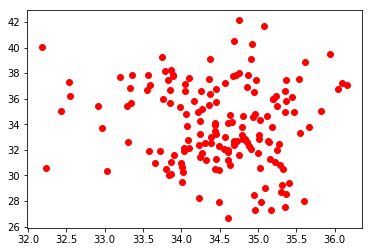

In [82]:
plt.plot(predicted, train_labels[:,1], "ro")

In [71]:
predicted.shape

(160, 1)

In [60]:
loss.item()

1194.63037109375

In [105]:
def train(num_epochs, lr=0.1):
  
    optmizer=optim.Adam(reg_model.parameters(),lr=lr)
    reg_best_model =copy.deepcopy(reg_model)
    best_kendall=0
    best_epoch=0
  
    for i in range(num_epochs):

        for mode in ["train","eval"]:

            accuracy=0
            loss_total=0

            if mode == "train":

                reg_model.train()
                for data, labels in loader_train:
                    data, labels=data.to(device), labels.to(device)
                    optmizer.zero_grad()
                    xTR_mean = reg_model(data)

                    #xRR_std, xTR_mean, xPR_mean=reg_model(data)
                    #LossRR_std = criterion(xRR_std,labels[:,2])
                    #LossTR_mean = criterion(xTR_mean,labels[:,1])
                    #LossPR_mean = criterion(xPR_mean,labels[:,0])
                    #loss = LossTR_mean
                    loss = F.mse_loss(xTR_mean,labels)
                    #LossRR_std + LossTR_mean + LossPR_mean
                    
                    loss.backward()
                    #torch.nn.utils.clip_grad_norm_(reg_model.parameters(), 0.01)
                    
                    optmizer.step()

                if i % 1000 == 0:
                    with torch.no_grad():
                        y_TR_mean= reg_model(data_train.to(device))
                        t = y_TR_mean.cpu().detach().squeeze().numpy()
                        kendallTR_mean = kendalltau(t, labels_train[:])
                        #kendallRR_std = kendalltau(xRR_std.cpu().detach().numpy(), labels[:,2].cpu().detach().numpy())[0]
                        #kendallPR_mean = kendalltau(xPR_mean.cpu().detach().numpy(), labels[:,0].cpu().detach().numpy())[0]
                        #kendallAvg = np.mean([kendallRR_std, kendallTR_mean, kendallPR_mean])

                        #print(f"Epoch{i} Training loss: {loss.item()}")
                        # print(f"Training RR STD loss: {LossRR_std.item()}")
                        #print(f"Training TR Mean loss: {LossTR_mean.item()}")
                        #print(f"Training PR Mean loss: {LossPR_mean.item()}")
                        print(f"TR Mean:f{kendallTR_mean[0]}")
                        #print(f"Training Avg Kendall: {kendallAvg}")


            if mode == "eval":

                reg_model.eval()
                for data, labels in loader_valid:
                    data, labels=data.to(device), labels.to(device)

                    with torch.no_grad():
                        optmizer.zero_grad()
                        xTR_mean = reg_model(data)

                        #xRR_std, xTR_mean, xPR_mean=reg_model(data)
                        #LossRR_std = criterion(xRR_std,labels[:,2])
                        #LossTR_mean = criterion(xTR_mean,labels[:,1])
                        #LossPR_mean = criterion(xPR_mean,labels[:,0])
                        #loss = LossTR_mean
                        loss = F.mse_loss(xTR_mean,labels)
                        #LossRR_std + LossTR_mean + LossPR_mean

                        loss_total+=loss

                if i % 1000 == 0:
                    with torch.no_grad():
                        #kendallRR_std = kendalltau(xRR_std.cpu().detach().numpy(), labels[:,2].cpu().detach().numpy())[0]
                        y_TR_mean= reg_model(data_train.to(device))
                        t = y_TR_mean.cpu().detach().squeeze().numpy()
                        kendallTR_mean = kendalltau(t, labels_train[:])
                        #kendallPR_mean = kendalltau(xPR_mean.cpu().detach().numpy(), labels[:,0].cpu().detach().numpy())[0]
                        #kendallAvg = np.mean([kendallRR_std, kendallTR_mean, kendallPR_mean])

                        print(f"Epoch{i} Training loss: {loss.item()}")
                       # print(f"Training RR STD loss: {LossRR_std.item()}")
                        #print(f"Training TR Mean loss: {LossTR_mean.item()}")
                        #print(f"Training PR Mean loss: {LossPR_mean.item()}")
                        print(f"TR Mean:f{kendallTR_mean[0]}")
                        #print(f"Training Avg Kendall: {kendallAvg}")
                    



                    #if kendallAvg > best_kendall:
                        #best_kendall = kendallAvg
                        #reg_best_model=copy.deepcopy(reg_model)
                        #best_epoch=i

    #print(f"The best epoch:{best_epoch} with an accuracy of {best_kendall}")

    return reg_model

In [109]:
reg_model = train(5000, 0.00001)

TR Mean:f-0.015256369927650205
Epoch0 Training loss: 10.777377128601074
TR Mean:f-0.015256369927650205
TR Mean:f-0.014784523435042468
Epoch1000 Training loss: 10.777883529663086
TR Mean:f-0.014784523435042468
TR Mean:f-0.013288775402047218
Epoch2000 Training loss: 10.777813911437988
TR Mean:f-0.013288775402047218
TR Mean:f-0.011952504558460485
Epoch3000 Training loss: 10.777796745300293
TR Mean:f-0.011952504558460485
TR Mean:f-0.008729503368787353
Epoch4000 Training loss: 10.777735710144043
TR Mean:f-0.008729503368787353


In [110]:
y_TR_mean= reg_model(data_train.to(device))

In [111]:
t = y_TR_mean.cpu().detach().squeeze().numpy()

In [112]:
kendalltau(t, labels_train[:])

KendalltauResult(correlation=-0.009043368858482604, pvalue=0.8652598025734298)

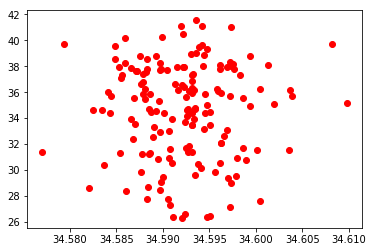

In [130]:
plt.plot(t, labels_train[:], "ro")

Regression Task Baseline PCA + Regressor

In [113]:
labels_train = train_labels[:]
labels_valid = valid_labels[:]

shuffle1 = np.random.permutation(len(Avg_template_train))
train_shuffle = Avg_template_train[shuffle1]
TrainLabel_shuffle = labels_train[shuffle1]
shuffle2 = np.random.permutation(len(Avg_template_valid))
valid_shuffle = Avg_template_valid[shuffle2]
ValidLabel_shuffle = labels_valid[shuffle2]

In [27]:
from sklearn.decomposition import PCA
ipca = PCA(n_components=30)
ipca.fit(train_shuffle)
pca_train = ipca.transform(train_shuffle)
pca_valid = ipca.transform(valid_shuffle)

In [48]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = [{'C': [1, 5, 10, 15, 100, 1000,10000], 'epsilon': [0.001, 0.0001,0.1,0.5,1,10], "degree" : [3,4]}]

svm = SVR(gamma="auto")
result = []
for i in range(3):
    clf = GridSearchCV(svm, param_grid, cv=5)
    clf.fit(pca_train, TrainLabel_shuffle[:,i])
    y_pred = clf.predict(pca_valid)
    print(LABELS_NAME[i])
    result.append(kendalltau(y_pred, ValidLabel_shuffle[:,i])[0])
    print(kendalltau(y_pred, ValidLabel_shuffle[:,i])[0])
    
print(np.mean(result))

PR_Mean
0.7367510705975453
RT_Mean
0.8732505218843478
RR_StdDev
0.25637800247804843
0.6221265316533139


In [114]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
result = []
for i in range(3):
    lin.fit(train_shuffle, TrainLabel_shuffle[:,i])
    y_pred = lin.predict(valid_shuffle)
    print(LABELS_NAME[i])
    result.append(kendalltau(y_pred, ValidLabel_shuffle[:,i])[0])
    print(kendalltau(y_pred, ValidLabel_shuffle[:,i])[0])
    
print(np.mean(result))

PR_Mean
0.3805629863065229
RT_Mean
0.6254128084880336
RR_StdDev
0.09143441180066553
0.36580340219840735


In [31]:
clf.best_params_

{'C': 10, 'degree': 3, 'epsilon': 1}

In [ ]:
kendalltau(xRR_std.cpu().detach().numpy(), labels[:,2].cpu().detach().numpy())[0]

In [74]:
y_pred[index_of_int]

array([11.,  3., 11., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 11., 31.,
       31., 31., 31.], dtype=float32)

In [ ]:
t_train_labels

In [16]:
R_peak_amplitude = [[preprocess_train[i][int(j)] for j in record] for i, record in enumerate(R_peak)]

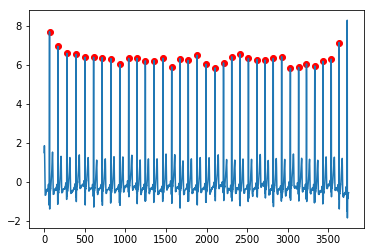

In [18]:
plt.plot(R_peak[5],R_peak_amplitude[5],"ro")
Plot_ECG(preprocess_train[5].cpu(),start=0,end=30)

for i in range(len(RR_std)):
    print((i,RR_std[i], train_labels[i,-2]))

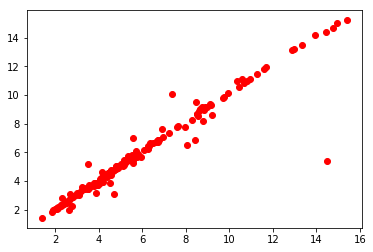

In [54]:
plt.plot(Train_RR_std, train_labels[:,-2], "ro")

In [57]:
kendalltau(Train_RR_std, train_labels[:,-2])[0]

0.9243710691823899

"PR_Mean", "RT_Mean"

In [32]:
S_numpy = preprocess_valid.cpu().numpy()

In [52]:
listoftemplate = []
listofQRS_offset = []
listofT_peak = []
listofT_offset = []
listofQRS_onset = []
listofP_peak = []
listofP_onset = []
listofR_Peak = []
R_peak = R_peak_valid
RR_interval_mean = Valid_RR_mean

for recording in range(len(R_peak)):
    #generate the template
    half_size_int = int(RR_interval_mean[recording]//2)
    template = np.ones((1,int(half_size_int*0.8)+int(half_size_int*1.2)))
    for i in R_peak[recording][1:-1]:
        new_heart_beat = S_numpy[recording][int(i)-int(half_size_int*0.8): int(i)+int(half_size_int*1.2)]
        template = np.concatenate((template,
                                   np.expand_dims(new_heart_beat, axis = 0))
                                   , axis=0)
    
    
    template = np.mean(template, axis = 0)
    
    #find QRS offset
    derivative = template[1:] - template[:-1] 
    TA = np.array([])
    TDA = np.array([])
    for i in range(int(half_size_int*0.8)+1, int(half_size_int*0.8)+25):
        TA = np.append(TA,np.max(template[i:i+4]) - np.min(template[i:i+4])) 
        TDA = np.append(TDA,np.max(derivative[i:i+4]) - np.min(derivative[i:i+4]))
    c1 = 0.1
    c2 = 0.1
    TT = c1 * (np.max(TA) - np.min(TA)) + np.min(TA)
    TD = c2 * (np.max(TDA) - np.min(TDA)) + np.min(TDA)
    
    for i in range(0, len(TA)):
        if TA[i] < TT or TDA[i] < TD:
            QRS_offset = i + int(half_size_int*0.8) + 4
            break
        
    #find T peak
    T_peak = QRS_offset + np.argmax(template[QRS_offset:])
    
    #find T wave offset
    
    k = (template[T_peak] - template[-1])/(T_peak-len(template))
    d = template[-1] - k*len(template)
    g = k*np.arange(0,len(template)) + d
    decision = template - g
    T_peak_offset = np.argmin(decision[T_peak:len(template)]) + T_peak
    
    #reverse the template
    reverse_template = np.flip(template)
    
    #Find the QRS onset
    derivative = reverse_template[1:] - reverse_template[:-1] 
    TA = np.array([])
    TDA = np.array([])
    for i in range(int(half_size_int*1.2)+1, int(half_size_int*1.2)+25):
        TA = np.append(TA,np.max(reverse_template[i:i+4]) - np.min(reverse_template[i:i+4])) 
        TDA = np.append(TDA,np.max(derivative[i:i+4]) - np.min(derivative[i:i+4]))
    c1 = 0.5
    c2 = 0.5
    TT = c1 * (np.max(TA) - np.min(TA)) + np.min(TA)
    TD = c2 * (np.max(TDA) - np.min(TDA)) + np.min(TDA)
    
    for i in range(0, len(TA)):
        if TA[i] < TT or TDA[i] < TD:
            QRS_onset = i + int(half_size_int*1.2) + 4
            break
    
    #Find the P peak
    P_peak = QRS_onset + np.argmax(reverse_template[QRS_onset:])  
    
    #Find the P onset
    
    k = (reverse_template[P_peak] - reverse_template[-1])/(P_peak-len(reverse_template))
    d = reverse_template[-1] - k*len(reverse_template)
    g = k*np.arange(0,len(reverse_template)) + d
    decision = reverse_template - g
    P_onset = np.argmin(decision[P_peak:len(reverse_template)]) + P_peak
    
    
    P_peak = len(template)-P_peak-1
    QRS_onset = len(template)-QRS_onset-1
    P_onset = len(template)-P_onset-1
    
    
    listofR_Peak.append(int(half_size_int*0.8)+1)
    listoftemplate.append(template)
    listofQRS_offset.append(QRS_offset)
    listofT_peak.append(T_peak)
    listofT_offset.append(T_peak_offset)
    listofQRS_onset.append(QRS_onset)
    listofP_peak.append(P_peak)
    listofP_onset.append(P_onset)
    

In [53]:
RT_Mean = [T_peak-R_peak+1 for T_peak,R_peak in zip(listofT_peak,listofR_Peak)]
PR_Mean = [R_peak-P_onset for R_peak,P_onset in zip(listofR_Peak,listofP_peak)]

In [54]:
PR_Mean2 = [QRS_onset-P_onset for QRS_onset,P_onset in zip(listofQRS_onset,listofP_onset)]

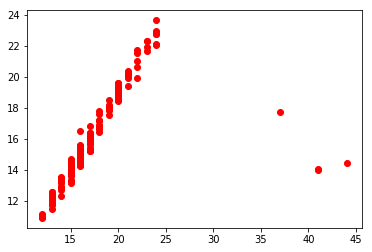

In [55]:
plt.plot(PR_Mean, valid_labels[:,0], "ro")

In [56]:
kendalltau(PR_Mean, valid_labels[:,0])

KendalltauResult(correlation=0.8697791379031147, pvalue=4.866409294148606e-55)

In [57]:
kendalltau(RT_Mean, valid_labels[:, 1])

KendalltauResult(correlation=0.9112549924246455, pvalue=9.830725944908511e-61)

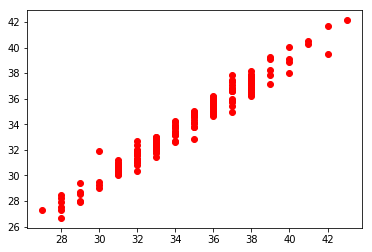

In [45]:
plt.plot(RT_Mean, valid_labels[:, 1], "ro")

In [118]:
kendalltau(list_RT_Mean, train_labels[:,-3])

KendalltauResult(correlation=0.8643121455155489, pvalue=4.085910602274134e-59)

In [119]:
kendalltau(RT_Mean, train_labels[:,-3])

KendalltauResult(correlation=0.9289062593216623, pvalue=2.961914504225467e-63)

In [ ]:
index_nb = 8
vizualize_ECG(listoftemplate[index_nb],0,len(listoftemplate[index_nb]),seconde=False)
plt.plot(listofR_Peak[index_nb]-1, listoftemplate[index_nb][listofR_Peak[index_nb]-1], "o")
plt.plot(listofQRS_offset[index_nb], listoftemplate[index_nb][listofQRS_offset[index_nb]], "o")
plt.plot(listofT_peak[index_nb], listoftemplate[index_nb][listofT_peak[index_nb]], "o")
plt.plot(listofT_offset[index_nb], listoftemplate[index_nb][listofT_offset[index_nb]], "o")
plt.plot(listofQRS_onset[index_nb], listoftemplate[index_nb][listofQRS_onset[index_nb]], "o")
plt.plot(listofP_peak[index_nb], listoftemplate[index_nb][listofP_peak[index_nb]], "o")
plt.plot(listofP_onset[index_nb], listoftemplate[index_nb][listofP_onset[index_nb]], "o")
plt.legend(["","R","QRS offset", "T", "T offset", "QRS onset","P", "P onset" ])

Lets try to improve the result by adding a layer of machine learning

In [110]:
import pandas as pd

In [111]:
ECG_train = pd.DataFrame()

In [113]:
ECG_train["heartbeat"] = RR_interval_mean
ECG_train["RR_std"] = RR_std
ECG_train["RT_Mean"] = RT_Mean
ECG_train["PR_Mean"] = PR_Mean
ECG_train["QRS_len"] = [QRS_offset-QRS_onset for QRS_offset,QRS_onset in zip(listofQRS_offset,listofQRS_onset)]
ECG_train["RT_Mean2"] = [T_offset-QRS_offset for T_offset,QRS_offset in zip(listofT_offset,listofQRS_offset)]
ECG_train["PR_Mean2"] =[QRS_onset-P_onset for QRS_onset,P_onset in zip(listofQRS_onset,listofP_onset)]
ECG_train["PT_Mean"] =[T_peak-P_peak for T_peak,P_peak in zip(listofT_peak,listofP_peak)]
ECG_train["R_peak_amplitude"] = [listoftemplate[index_nb][R_peak-1] for index_nb, R_peak in enumerate(listofR_Peak)]
ECG_train["P_peak_amplitude"] = [listoftemplate[index_nb][P_peak] for index_nb, P_peak in enumerate(listofP_peak)]
ECG_train["T_peak_amplitude"] = [listoftemplate[index_nb][T_peak] for index_nb, T_peak in enumerate(listofT_peak)]

In [126]:
idtransformer = id_trasformer()
idtransformer.create_dict_ID(train_labels[:,-1])
train_labels[:,-1] = idtransformer.Id2Class(train_labels[:,-1])
valid_labels[:,-1] = idtransformer.Id2Class(valid_labels[:,-1])

In [116]:
x_valid = np.array(ECG_train)

In [61]:
x=np.array(ECG_train)

In [129]:
shuffle = np.random.permutation(160)
train_shuffle = x[shuffle]
TrainLabel_shuffle = train_labels[shuffle]
valid_shuffle = x_valid[shuffle]
ValidLabel_shuffle = valid_labels[shuffle]

ID task this will give a baseline to beat

In [171]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [174]:
forest = LinearDiscriminantAnalysis()
forest.fit(train_shuffle, TrainLabel_shuffle[:,-1])
y_pred = forest.predict(valid_shuffle)
forest.score(valid_shuffle, ValidLabel_shuffle[:,-1])

/miniconda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.48125

In [134]:
forest = ExtraTreesClassifier(n_estimators=1000,
                              random_state=0, oob_score=True, bootstrap=True)
forest.fit(train_shuffle, TrainLabel_shuffle[:,-1])
print(forest.oob_score_)
y_pred = forest.predict(valid_shuffle)
forest.score(valid_shuffle, ValidLabel_shuffle[:,-1])

0.78125


0.45

In [175]:
ecgIdAccuracy = recall_score(ValidLabel_shuffle[:,-1], y_pred, average='macro')
adjustementTerm = 1.0 / len(np.unique(ValidLabel_shuffle[:,-1]))
ecgIdAccuracy = (ecgIdAccuracy - adjustementTerm) / (1 - adjustementTerm)
if ecgIdAccuracy < 0:
    ecgIdAccuracy = 0.0
print(ecgIdAccuracy)

0.46451612903225814


Regression Task

In [152]:
forest = RandomForestRegressor(n_estimators=500,
                              random_state=0, bootstrap=True)
forest.fit(train_shuffle, TrainLabel_shuffle[:,-2])
y_pred = forest.predict(valid_shuffle)
kendalltau(y_pred, ValidLabel_shuffle[:,-2])

KendalltauResult(correlation=0.841621133556427, pvalue=3.361077295023981e-56)

In [153]:
forest = RandomForestRegressor(n_estimators=500,
                              random_state=0, bootstrap=True)
forest.fit(train_shuffle, TrainLabel_shuffle[:,-3])
y_pred = forest.predict(valid_shuffle)
kendalltau(y_pred, ValidLabel_shuffle[:,-3])

KendalltauResult(correlation=0.8685327989136057, pvalue=1.0143556843011926e-59)

In [154]:
forest = RandomForestRegressor(n_estimators=500,
                              random_state=0, bootstrap=True)
forest.fit(train_shuffle, TrainLabel_shuffle[:,-4])
y_pred = forest.predict(valid_shuffle)
kendalltau(y_pred, ValidLabel_shuffle[:,-4])

KendalltauResult(correlation=0.843528867168673, pvalue=1.9595342735005284e-56)

No improvement here

In [156]:
from sklearn.linear_model import LinearRegression

In [160]:
for i in range(3):
    linear = LinearRegression()
    linear.fit(train_shuffle, TrainLabel_shuffle[:,i])
    y_pred = linear.predict(valid_shuffle)
    print(kendalltau(y_pred, ValidLabel_shuffle[:,i]))

KendalltauResult(correlation=0.7024689503434867, pvalue=1.1128367743913108e-39)
KendalltauResult(correlation=0.8812706509346092, pvalue=1.975081609541191e-61)
KendalltauResult(correlation=0.8350171003739197, pvalue=2.380900142611868e-55)


No improvement also

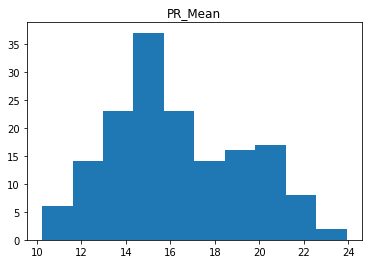

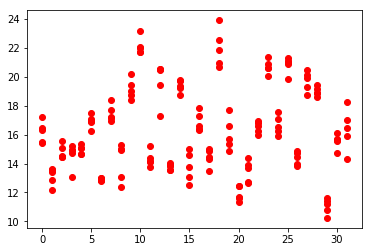

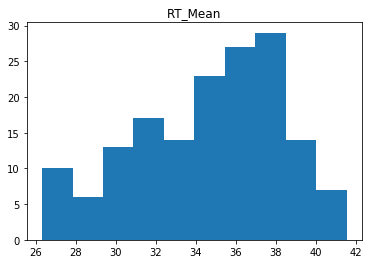

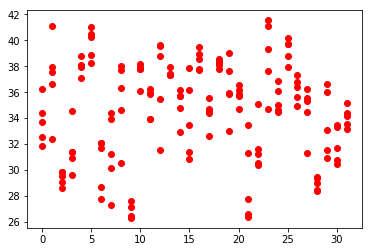

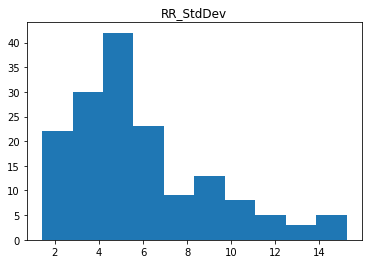

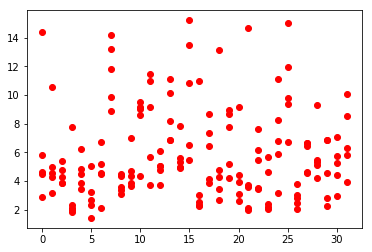

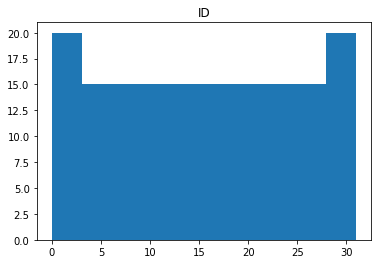

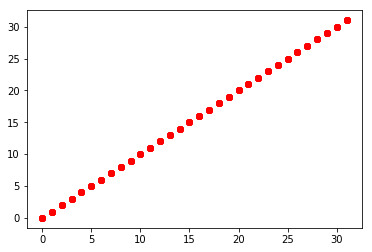

In [23]:
def vizualize_label(label_name=LABELS_NAME, type_data=train_labels):
    # Plot histogram of the label to see their distribution
    # Not complete 
    for i, ex in enumerate(label_name):
        plt.figure(i*2+1) #to let the index start at 1
        plt.title(ex)
        plt.hist(train_labels[:,i])
        plt.figure(i*2+2)
        plt.plot(train_labels[:,-1], train_labels[:,i],"ro")
    plt.show()
    
vizualize_label()